In [61]:
# MLflow
import mlflow
from mlflow.models import infer_signature

# MLflow model
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Visualizations
import matplotlib.pyplot as plt

# math functions
import numpy as np

# read CSV file
import os
import glob

# data frames
import pandas as pd

# regexes
import re

# Print pandas.describe() in PDF
from prettytable import PrettyTable

# converting created dates from reddit API into human readable format
from datetime import datetime, timedelta

In [62]:
# Disable automated output
import warnings
# Future deprecation warnings
warnings.filterwarnings("ignore")
import logging
# Set logging level to suppress INFO messages
logging.getLogger('mlflow').setLevel(logging.WARNING)

In [63]:
# https://medium.com/bitgrit-data-science-publication/sentiment-analysis-on-reddit-tech-news-with-python-cbaddb8e9bb6

# Load NLTK Libraries

# sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, RegexpTokenizer # tokenize words
from nltk.corpus import stopwords

# Downloading NLTK's databases
nltk.download('vader_lexicon', quiet=True); # get lexicons data
nltk.download('punkt', quiet=True); # for tokenizer
nltk.download('stopwords', quiet=True); # dictionary for tokenization


In [64]:
# visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) # default plot size
import seaborn as sns
sns.set(style='whitegrid', palette='Dark2')
from wordcloud import WordCloud

In [65]:
import zipfile
# Unzip files to raw output

output_folder = '/'.join(['output','model'])
zip_folder = '/'.join(['output','zip'])
# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Loop through each zip file in the input folder
for zip_file in os.listdir(zip_folder):
    if zip_file.endswith('.zip'):
        zip_path = os.path.join(zip_folder, zip_file)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            # Extract all contents of the zip file to the output folder
            zip_ref.extractall(output_folder)


# Reddit Subreddit API analysis

Subreddit Stats
+----------------------+-------+-------------+----------------------+-----------------+
|         name         | index | subscribers |     display_name     | subscribers_pct |
+----------------------+-------+-------------+----------------------+-----------------+
|       chatgpt        |   1   |   4505500   |       chatgpt        |      36.55      |
|   machinelearning    |   10  |   2870456   |   MachineLearning    |      23.28      |
|     datascience      |   4   |   1366348   |     datascience      |      11.08      |
|        openai        |   11  |   1124730   |        OpenAI        |       9.12      |
|         gpt3         |   7   |    722076   |         GPT3         |       5.86      |
|      artificial      |   0   |    720095   |      artificial      |       5.84      |
| learnmachinelearning |   9   |    384514   | learnmachinelearning |       3.12      |
| chatgptpromptgenius  |   3   |    193280   | ChatGPTPromptGenius  |       1.57      |
|       datasets

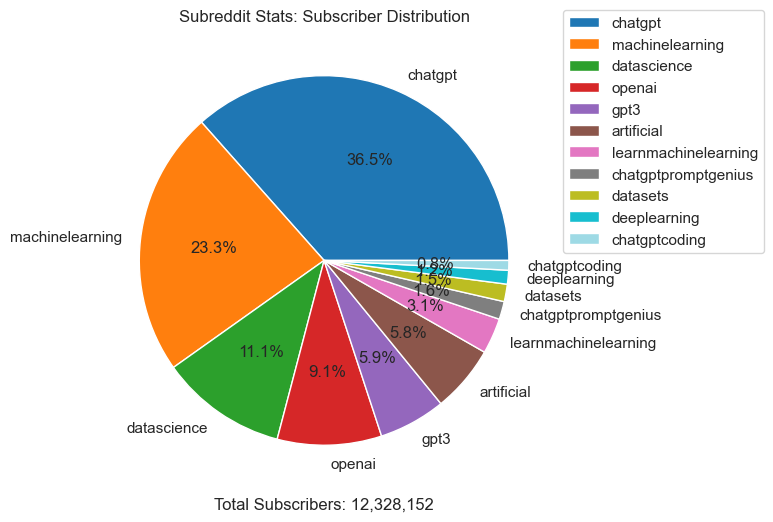

In [66]:
# Reddit metadata structure
subreddit_dict = {  "name":[],
                    "subscribers":[] }

# Import subreddit metadata
metadata = pd.DataFrame()
for fname in glob.iglob(os.path.abspath('/'.join([output_folder, '/**/*.meta'])), recursive=True):
    _metadata = pd.read_csv(fname)
    metadata = metadata.append(_metadata.copy())
    #print(fname)
    #break #DEBUG

print('Subreddit Stats')
# Create a PrettyTable object
table = PrettyTable()
# Add columns to the table
table.field_names = metadata.columns
# Add rows to the table
for row in metadata.itertuples(index=False):
    # Set the float format for all float columns
    float_format = "{:.2f}"
    # Format float values
    row = [float_format.format(value) if isinstance(value, float) else value for value in row]
    table.add_row(row)
# Print the table
print(table)

# Set index to the name for pie charts
metadata.reset_index(inplace=True)
# After printing, set name as the index
metadata.set_index('name', inplace=True)  # Set the 'name' column as the index of the DataFrame

# Plot pie chart of sentiment label distribution
plt.figure(figsize=(8, 6))
colors = plt.cm.tab20(np.linspace(0, 1, len(metadata)))
metadata['subscribers_pct'].plot(kind='pie', autopct='%1.1f%%', colors=colors)
# Add annotations for subscriber percentages
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.title('Subreddit Stats: Subscriber Distribution')
plt.ylabel('')
plt.xlabel('Total Subscribers: ' + "{:,}".format(metadata['subscribers'].sum()))
plt.show()

# Reddit Search API data analysis

In [67]:
# Import query data
df_files = {}
running_total = 0
for fname in glob.glob(os.path.abspath('/'.join([output_folder, '/**/gpt*.csv'])), recursive=True):
    filename = os.path.splitext(os.path.basename(fname))[0]
    _df=pd.read_csv(fname)
    _df['date'] = pd.to_datetime(_df['date']) # convert date column
    _df['comment_date'] = pd.to_datetime(_df['comment_date']) # convert date column
    df_files[filename] = pd.DataFrame(_df)
    running_total+=len(_df)
    #print(fname)
    #print(running_total)
    #break #DEBUG

df = pd.concat(df_files)
print(f"Total imported Reddit comments: {running_total}")

Total imported Reddit comments: 51133


# Data split on launch dates

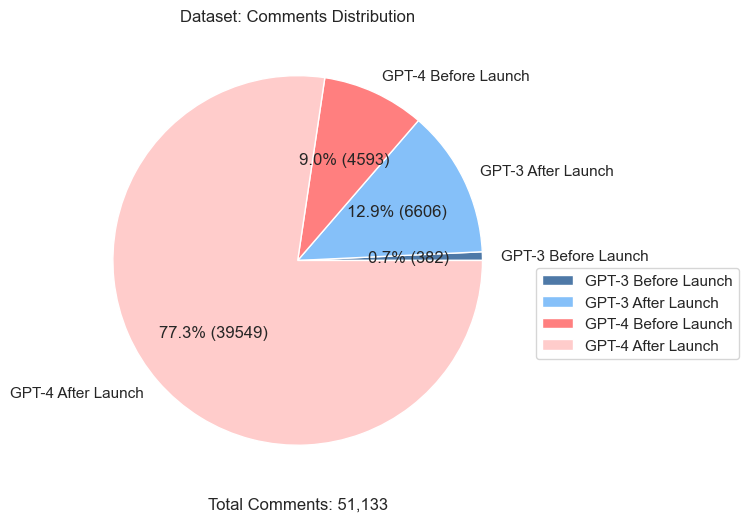

In [68]:
# Define the date range for GPT-3 hype analysis
gpt3_start = datetime(2022, 11, 1)
gpt3_launch = datetime(2022, 11, 30)
gpt3_end = datetime(2023, 1, 31)

# Define the date range for GPT-4 hype analysis
gpt4_start = datetime(2023, 2, 15)
gpt4_launch =  datetime(2023, 3, 14)
gpt4_end = datetime(2023, 5, 15)

# Filter GPT-3 dataset
df_gpt3 = df[(gpt3_start <= df['date']) & (df['date'] < gpt3_end + timedelta(days=1))]
df_gpt3 = df_gpt3[(gpt3_start <= df_gpt3['comment_date']) & (df_gpt3['comment_date'] < gpt3_end + timedelta(days=1))]
# get the distance of the date to the GPT-3 launch date
df_gpt3['launch_distance'] = abs(gpt3_launch - df_gpt3['date'])
df_gpt3['comment_launch_distance'] = abs(gpt3_launch - df_gpt3['comment_date'])
df_gpt3['launch_distance_f'] = df_gpt3['launch_distance'] / pd.to_timedelta(1, unit='D')
df_gpt3['comment_launch_distance_f'] = df_gpt3['comment_launch_distance'] / pd.to_timedelta(1, unit='D')


# Filter GPT-4 dataset
df_gpt4 = df[(gpt4_start <= df['date']) & (df['date'] < gpt4_end + timedelta(days=1))]
df_gpt4 = df_gpt4[(gpt4_start <= df_gpt4['comment_date']) & (df_gpt4['comment_date'] < gpt4_end + timedelta(days=1))]
# get the distance of the date to the GPT-4 launch date
df_gpt4['launch_distance'] = abs(gpt4_launch - df_gpt4['date'])
df_gpt4['comment_launch_distance'] = abs(gpt4_launch - df_gpt4['date'])
df_gpt4['launch_distance_f'] = df_gpt4['launch_distance'] / pd.to_timedelta(1, unit='D')
df_gpt4['comment_launch_distance_f'] = df_gpt4['comment_launch_distance'] / pd.to_timedelta(1, unit='D')

# Split at gpt3_launch date
df_gpt3_before = df_gpt3[df_gpt3['date'] < gpt3_launch]
df_gpt3_after = df_gpt3[gpt3_launch <= df_gpt3['date']]
# Split at gpt4_launch date
df_gpt4_before = df_gpt4[df_gpt4['date'] < gpt4_launch]
df_gpt4_after = df_gpt4[gpt4_launch <= df_gpt4['date']]

# Get counts of datasets before and after launch dates
df_gpt_counts = {
    'GPT-3 Before Launch': len(df_gpt3_before),
    'GPT-3 After Launch': len(df_gpt3_after),
    'GPT-4 Before Launch': len(df_gpt4_before),
    'GPT-4 After Launch': len(df_gpt4_after)
}
# Plot pie chart of GPT search distribution
plt.figure(figsize=(8, 6))
colors = ['#4e79a7', '#85c0f9', '#ff7f7f', '#ffcccb']  
plt.pie(df_gpt_counts.values(), colors=colors, labels=df_gpt_counts.keys(), autopct=lambda pct: f"{pct:.1f}% ({int(pct/100*sum(df_gpt_counts.values()))})")
# Add annotations for subscriber percentages
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title('Dataset: Comments Distribution')
plt.ylabel('')
plt.xlabel('Total Comments: ' + "{:,}".format(sum(df_gpt_counts.values())))
plt.show()

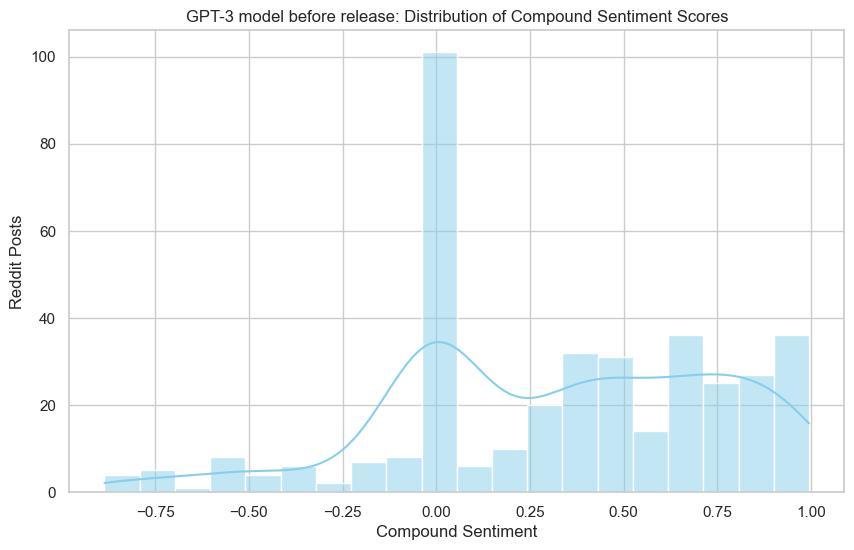

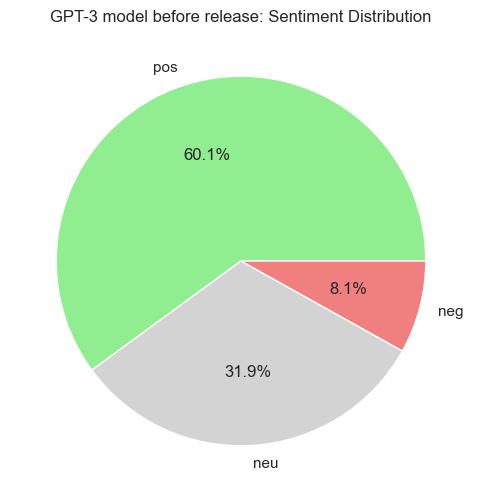

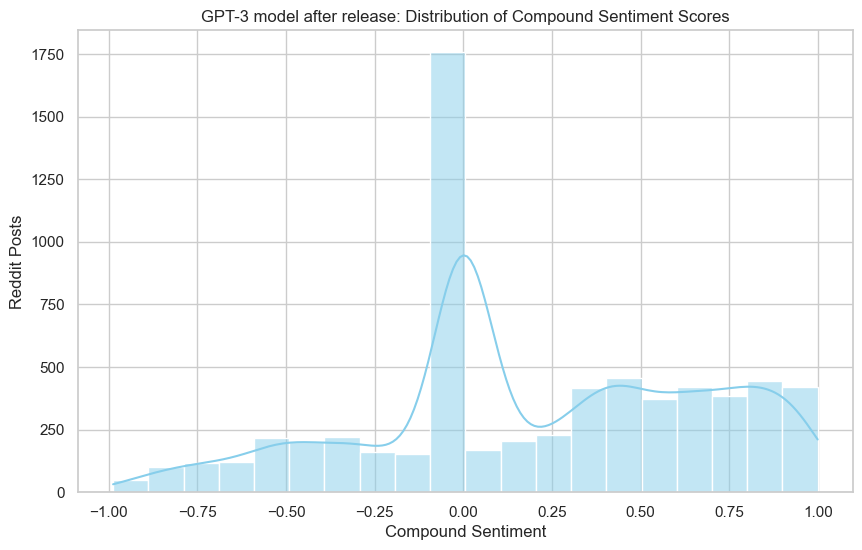

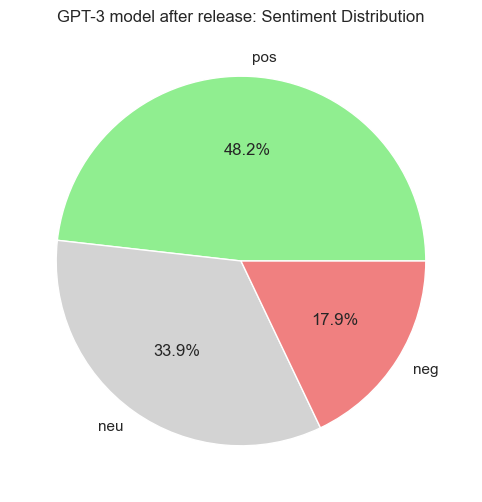

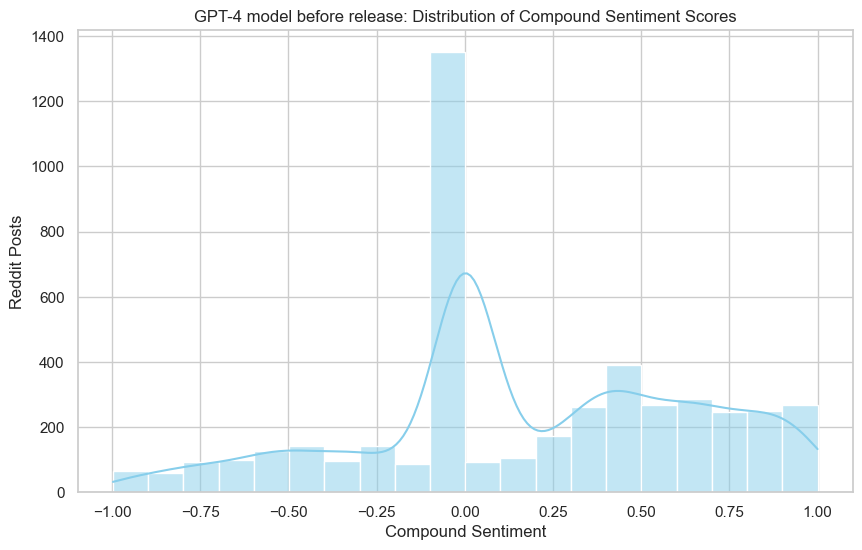

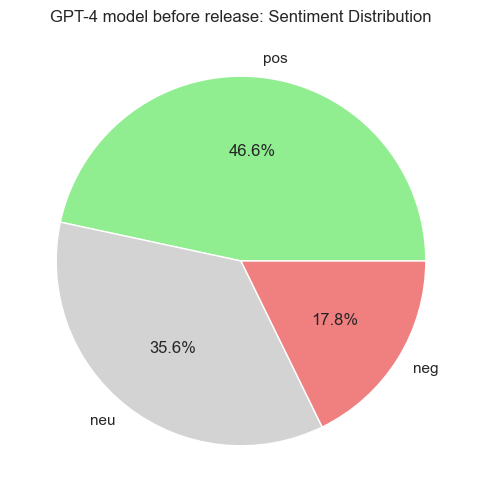

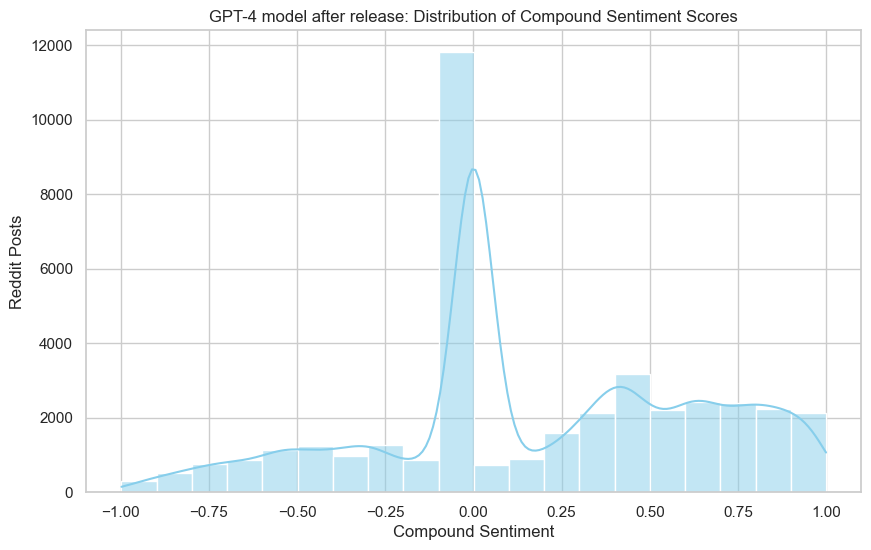

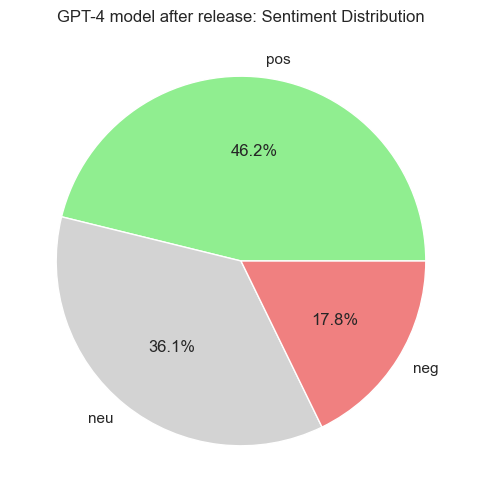

In [69]:
def visualize_sentiment(dataset, name):
    # Plot histogram of compound sentiment scores
    plt.figure(figsize=(10, 6))
    sns.histplot(data=dataset, x='comment_body_compound', bins=20, kde=True, color='skyblue')
    plt.title(name + ': Distribution of Compound Sentiment Scores')
    plt.xlabel('Compound Sentiment')
    plt.ylabel('Reddit Posts')
    plt.show()

    # Plot pie chart of sentiment label distribution
    plt.figure(figsize=(8, 6))
    dataset['comment_body_sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'lightgray', 'lightcoral'])
    plt.title(name + ': Sentiment Distribution')
    plt.ylabel('')
    plt.show()
visualize_sentiment(dataset=df_gpt3_before, name='GPT-3 model before release')
visualize_sentiment(dataset=df_gpt3_after, name='GPT-3 model after release')
visualize_sentiment(dataset=df_gpt4_before, name='GPT-4 model before release')
visualize_sentiment(dataset=df_gpt4_after, name='GPT-4 model after release')

# Time Series Analysis

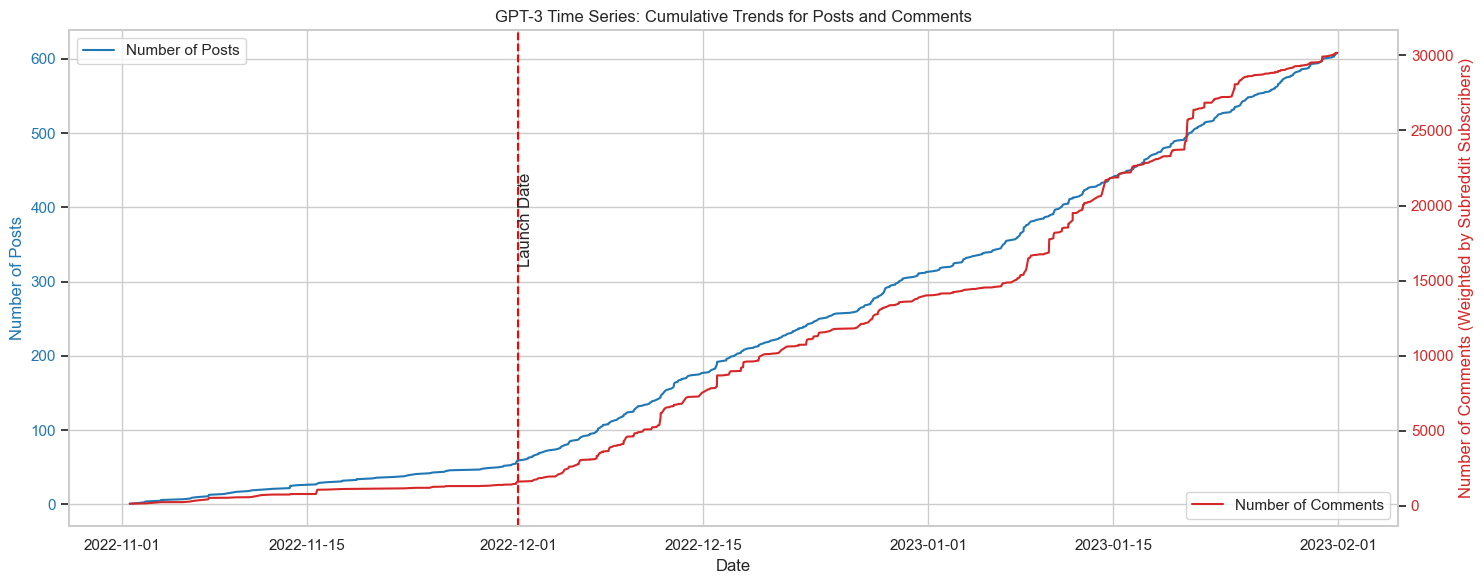

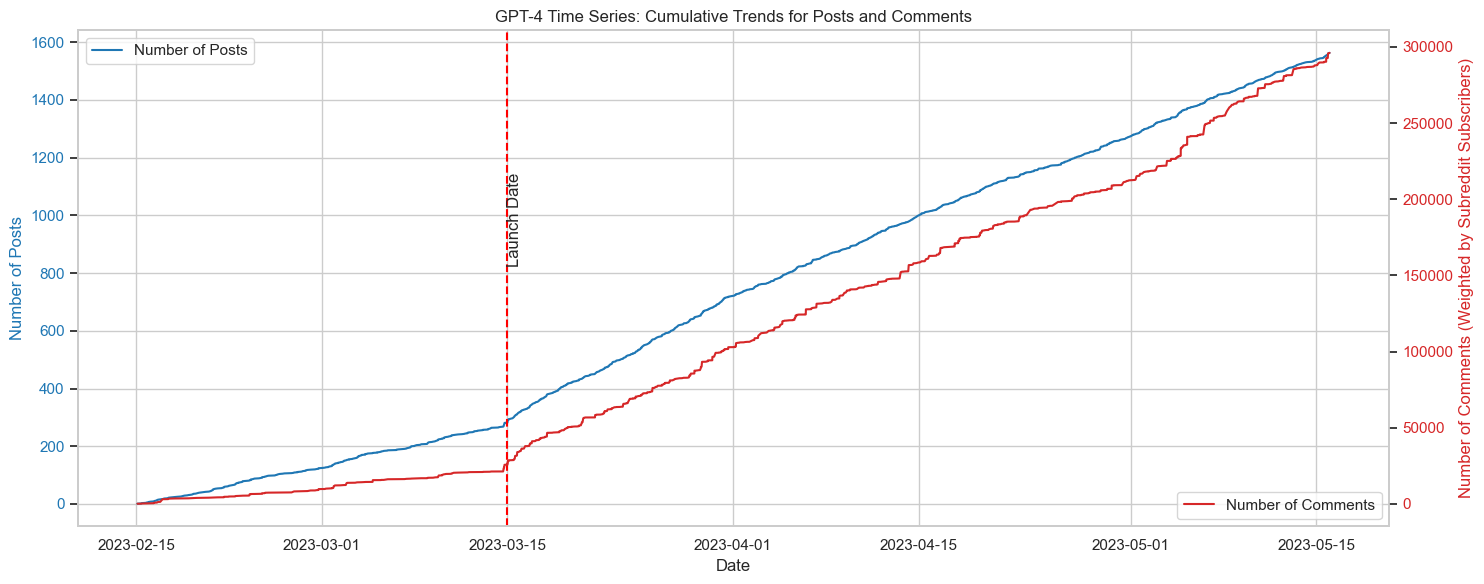

In [70]:
def plot_model_time_series(model, model_name, launch_date):
    model['count_cumulative'] = model['date'].apply(lambda date: len(model[model['date'] <= date]))
    model['num_comments_cumulative'] = model['num_comments_weighted'].cumsum()
    
    fig, ax1 = plt.subplots(figsize=(15, 6))  # Create figure and axes
    
    # Plot cumulative posts per day
    ax1.plot(model['date'], model['count_cumulative'], color='tab:blue', label='Number of Posts')
    ax1.set_ylabel('Number of Posts', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    
    # Create a second y-axis for number of comments
    ax2 = ax1.twinx()
    ax2.plot(model['date'], model['num_comments_cumulative'], color='tab:red', label='Number of Comments')
    ax2.set_ylabel('Number of Comments (Weighted by Subreddit Subscribers)', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.legend(loc='lower right')  # Show legend for comments
    
    ax1.set_title(model_name + ': Cumulative Trends for Posts and Comments')
    ax1.set_xlabel('Date')
    ax1.axvline(x=launch_date + timedelta(days=1), color='r', linestyle='--')  # Vertical line for launch date
    ax1.text(launch_date + timedelta(days=1), ax1.get_ylim()[1] * .5, 'Launch Date', rotation=90, verticalalignment='bottom')
    ax1.legend(loc='upper left')  # Show legend for posts
    
    ax2.grid(False)  # Remove y-axis gridlines
    
    plt.tight_layout()
    plt.show()

# Plot GPT-3 data by date
df_gpt3_time_series = pd.concat([df_gpt3_before, df_gpt3_after]).sort_values(by='date')
df_gpt3_time_series.reset_index(inplace=True)  # Reset index
df_gpt3_time_series.drop_duplicates(subset='id', inplace=True)  # Drop duplicates based on the 'id' column
df_gpt3_time_series.set_index('id', inplace=True)  # Set the 'id' column as the index of the DataFrame
plot_model_time_series(df_gpt3_time_series, 'GPT-3 Time Series', gpt3_launch)

# Plot GPT-4 data by date
df_gpt4_time_series = pd.concat([df_gpt4_before, df_gpt4_after]).sort_values(by='date')
df_gpt4_time_series.reset_index(inplace=True)  # Reset index
df_gpt4_time_series.drop_duplicates(subset='id', inplace=True)  # Drop duplicates based on the 'id' column
df_gpt4_time_series.set_index('id', inplace=True)  # Set the 'id' column as the index of the DataFrame
plot_model_time_series(df_gpt4_time_series, 'GPT-4 Time Series', gpt4_launch)

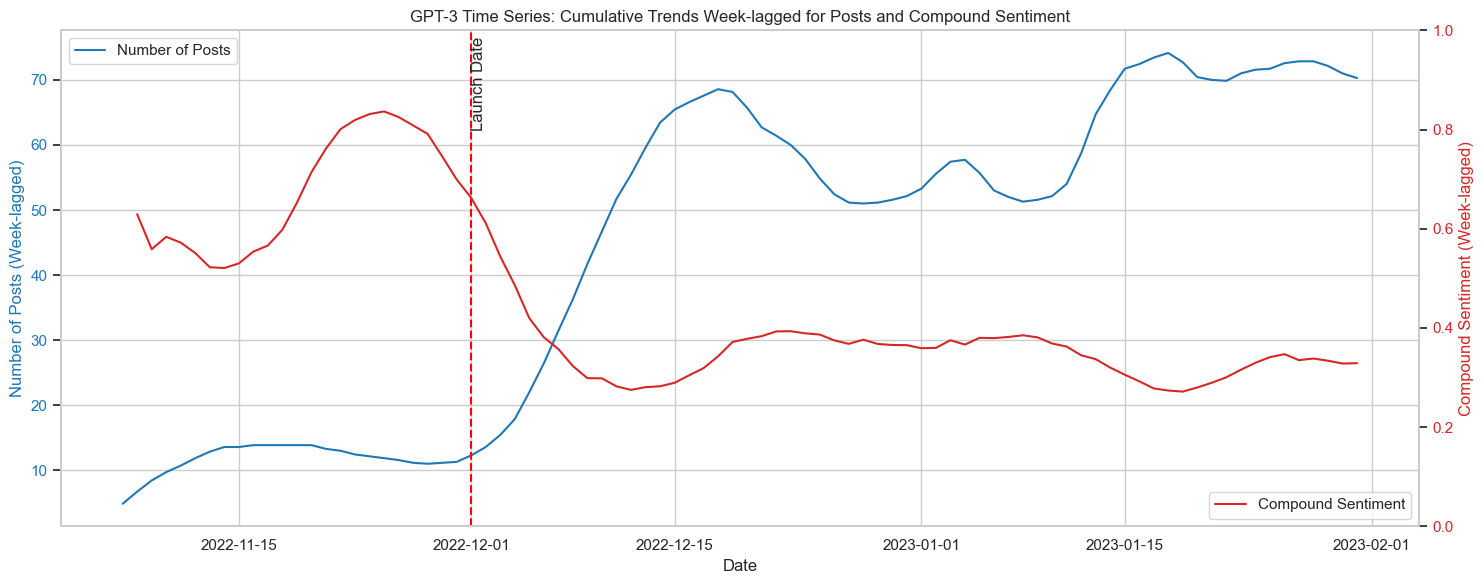

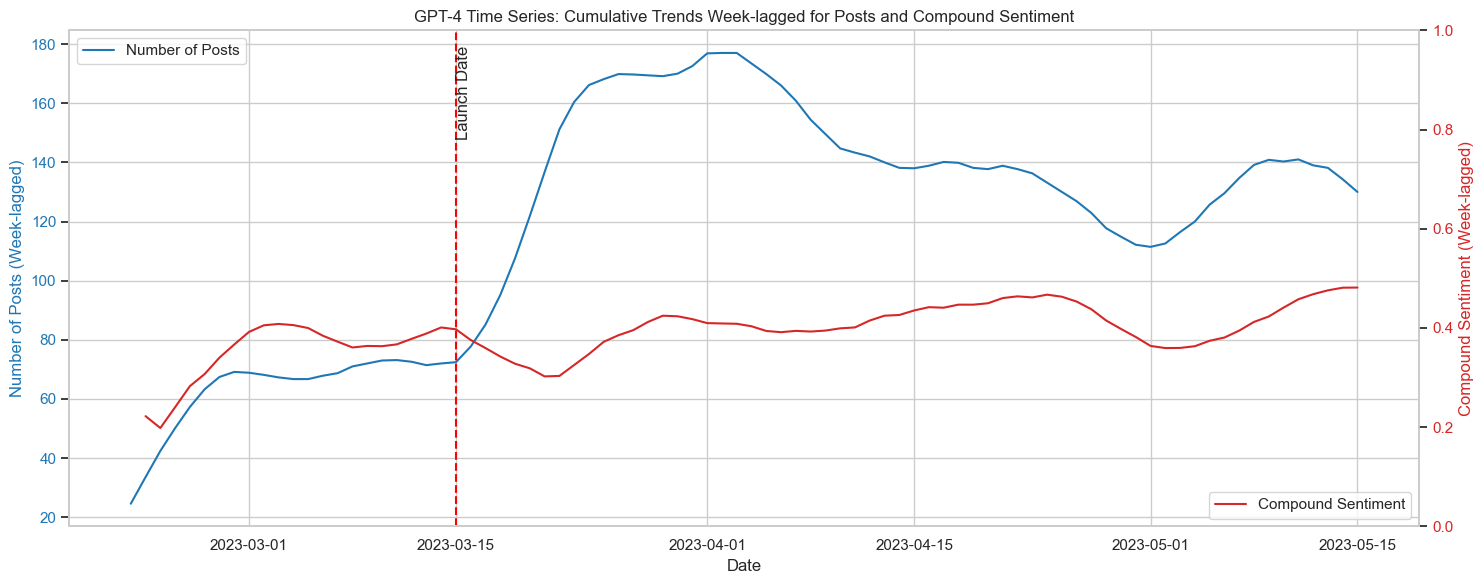

In [71]:
def plot_time_series_lagged(model, model_name, start_date, end_date, launch_date):
    # Sort by date
    _model = model.sort_values(by='date')

    # Create a DataFrame with the dates
    df_time_series = pd.DataFrame({'date': pd.date_range(start=start_date, end=end_date)})

    # Calculate the total comments for the past week, then take the lagged average for that week
    df_time_series['count_cumulative'] = df_time_series['date'].apply(lambda date: len(_model[
        (date - timedelta(days=7) < _model['date']) & (_model['date'] <= date)
    ]))
    df_time_series['count_cumulative_lagged'] = df_time_series['count_cumulative'].rolling(window=7).mean()

    # Calculate the average sentiment for the past week, then take the lagged average for that week
    df_time_series['compound_cumulative'] = df_time_series['date'].apply(lambda date: _model[
        (date - timedelta(days=7) < _model['date']) & (_model['date'] <= date)
    ]['text_compound'].mean())
    df_time_series['compound_cumulative_lagged'] = df_time_series['compound_cumulative'].rolling(window=7).mean()


    fig, ax1 = plt.subplots(figsize=(15, 6))  # Create figure and axes
    
    # Plot cumulative posts per day
    ax1.plot(df_time_series['date'], df_time_series['count_cumulative_lagged'], color='tab:blue', label='Number of Posts')
    ax1.set_ylabel('Number of Posts (Week-lagged)', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    
    # Create a second y-axis for number of comments
    ax2 = ax1.twinx()
    ax2.plot(df_time_series['date'], df_time_series['compound_cumulative_lagged'], color='tab:red', label='Compound Sentiment')
    ax2.set_ylabel('Compound Sentiment (Week-lagged)', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.legend(loc='lower right')  # Show legend for comments
    ax2.set_ylim(0, 1)  # Set y-axis limits for compound sentiment
    
    ax1.set_title(model_name + ': Cumulative Trends Week-lagged for Posts and Compound Sentiment')
    ax1.set_xlabel('Date')
    ax1.axvline(x=launch_date + timedelta(days=1), color='r', linestyle='--')  # Vertical line for launch date
    ax1.text(launch_date + timedelta(days=1), ax1.get_ylim()[1] * .8, 'Launch Date', rotation=90, verticalalignment='bottom')
    ax1.legend(loc='upper left')  # Show legend for posts
    
    ax2.grid(False)  # Remove y-axis gridlines
    
    plt.tight_layout()
    plt.show()
    return _model

# Plot GPT-3 data by date
df_gpt3_time_series_sentiment = plot_time_series_lagged(df_gpt3_time_series, 'GPT-3 Time Series', gpt3_start, gpt3_end, gpt3_launch)

# Plot GPT-4 data by date
df_gpt4_time_series_sentiment = plot_time_series_lagged(df_gpt4_time_series, 'GPT-4 Time Series', gpt4_start, gpt4_end, gpt4_launch)

# Preparing MLflow features and targets

In [72]:
# Features to measure with MLflow
feature_names = ['upvote_ratio', 'launch_distance_f', 'num_comments_weighted', 'score_weighted',
                 'comment_score_weighted', 'comment_launch_distance_f', 'comment_num_replies_weighted', 
                 'comment_body_compound', 'comment_body_pos', 'comment_body_neg', 'comment_body_neu']
# Target MLflow value
target_name = 'comment_score_weighted'
# these variables should be represented as log of the original values
log_variables = ['launch_distance_f', 'num_comments_weighted', 'score_weighted',
                 'comment_score_weighted','comment_num_replies_weighted', 'comment_launch_distance_f', 'comment_num_replies_weighted']

def clean_dataset(dataset, csv_name, inplace=True):
    global log_variables, feature_names, target_name
    if inplace is True:
        _dataset = dataset
    else:
        _dataset = dataset.copy()
    for variable in log_variables:
        # Rename the variables to log_[variable] in the datasets
        log_variable = 'log_'+variable
        if target_name == variable:
            target_name = log_variable
        elif variable in feature_names:
            feature_names[feature_names.index(variable)] = log_variable
        _dataset[log_variable] = _dataset[variable].apply(lambda value: np.log(value+1))
    _dataset.dropna(subset=feature_names, how="any", inplace=inplace)
    _dataset.dropna(subset=target_name, how="any", inplace=inplace)
    _dataset = _dataset.sort_index()

clean_dataset(df_gpt3_before, 'gpt3-before')
clean_dataset(df_gpt3_after, 'gpt3-after')
clean_dataset(df_gpt4_before, 'gpt4-before')
clean_dataset(df_gpt4_after, 'gpt4-after')

# These features are disabled. Targets should be removed and sentiment scores apply too much affect to outcome
for feature in [target_name, 
                # Below are characteristics of the post, not the comments
                #'upvote_ratio', 'launch_distance_f', 'num_comments_weighted', 'score_weighted',
                'comment_body_pos', 'comment_body_neg', 'comment_body_neu']: feature_names.remove(feature)

print(f"feature_names={feature_names}")
print(f"target_name={target_name}")

feature_names=['upvote_ratio', 'log_launch_distance_f', 'log_num_comments_weighted', 'log_score_weighted', 'log_comment_launch_distance_f', 'log_comment_num_replies_weighted', 'comment_body_compound']
target_name=log_comment_score_weighted


In [73]:
def describe_dataset(dataset, name):
    print(name)
    description_table = dataset.describe()

    # Convert the 'created' column to datetime
    description_table['created'] = pd.to_datetime(description_table['created'], unit='s')

    description_table = description_table.transpose()
    description_table.reset_index(inplace=True)

    # Create a PrettyTable object for the first half of columns
    table1 = PrettyTable()
    table1.field_names = description_table.columns[:1+len(description_table.columns)//2]

    # Create a PrettyTable object for the second half of columns, including the first column
    table2 = PrettyTable()
    table2.field_names = ['index'] + list(description_table.columns[1+len(description_table.columns)//2:])

    # Set the float format for all float columns
    float_format = "{:.2f}"

    # Set the timedelta format
    def format_timedelta(td):
        days = td.days
        hours, remainder = divmod(td.seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        return f"{days} days" # {hours:02}:{minutes:02}:{seconds:02}
    
    # Format date
    def format_date(dt):
        return dt.strftime("%Y-%m-%d") # %H:%M:%S

    # Add rows to the tables
    for row in description_table.itertuples(index=False):
        # Convert timedelta values to formatted strings
        row = list(row)
        for i, value in enumerate(row):
            if isinstance(value, pd.Timedelta):
                row[i] = format_timedelta(value)
            elif isinstance(value, pd.Timestamp):
                row[i] = format_date(value)
        # Format float values
        row = [float_format.format(value) if isinstance(value, float) else value for value in row]
        # Add row to the first table
        table1.add_row(row[:1+len(description_table.columns)//2])
        # Add row to the second table
        table2.add_row([row[0]] + row[1+len(description_table.columns)//2:])

    # Print the tables
    print(table1)
    print(table2)

describe_dataset(dataset=df_gpt3_before, name='GPT-3 model before release')
describe_dataset(dataset=df_gpt3_after, name='GPT-3 model after release')
describe_dataset(dataset=df_gpt4_before, name='GPT-4 model before release')
describe_dataset(dataset=df_gpt4_after, name='GPT-4 model after release')

GPT-3 model before release
+----------------------------------+------------+------------+------------+------------+
|              index               |   count    |    mean    |    std     |    min     |
+----------------------------------+------------+------------+------------+------------+
|             index_x              |   383.00   |  1680.14   |   531.36   |   134.00   |
|             stickied             |   383.00   |    0.00    |    0.00    |    0.00    |
|           upvote_ratio           |   383.00   |    0.91    |    0.11    |    0.43    |
|              score               |   383.00   |   191.86   |   162.64   |    0.00    |
|           num_comments           |   383.00   |   77.23    |   76.14    |    1.00    |
|             created              | 1970-01-01 | 2022-11-13 | 1970-01-08 | 2022-11-01 |
|             text_neg             |   383.00   |    0.02    |    0.04    |    0.00    |
|             text_neu             |   383.00   |    0.84    |    0.10    |    0.41

# Run MLflow experiment
Linear regression analysis. Remove "stickied" Reddit posts from data.

Test model against data after GPT-4 launch.

In [80]:
# Enable automatic logging to MLflow
mlflow.set_experiment("Reddit GPT Hype")
mlflow.autolog()

def trim_dataset(dataset, q_lower = 0, q_upper = 1):
    global target_name
    quantile = target_name
    _dataset = dataset.copy()
    # Trim dataset by the quantile for the target for training
    _q_lower = _dataset[quantile].quantile(q_lower)
    _q_upper = _dataset[quantile].quantile(q_upper)
    _dataset = _dataset[(_dataset[quantile] >= _q_lower) &
                        (_dataset[quantile] <= _q_upper)]
    return _dataset

def model_testing(dataset, test):
    _dataset = dataset.copy()
    _test = test.copy()
    # Trim upper and lower quantiles
    _dataset = trim_dataset(_dataset)
    _test = trim_dataset(_test)
    # Sort values for displaying in graph
    _dataset = dataset
    _test = _test
    # Set X features and y targets
    X_test = _test.loc[:, _test.columns[:,None] == feature_names]
    y_test = _test.loc[:, _test.columns == target_name].values
    X = _dataset.loc[:, _dataset.columns[:,None] == feature_names]
    y = _dataset.loc[:, _dataset.columns == target_name].values

    lr_params =  {}
    lr = LinearRegression(**lr_params)

    # MLflow triggers logging automatically upon model fitting
    lr.fit(X, y)
    y_pred = lr.predict(X_test)

    return {'X': X, 'y': y, 'X_test': X_test, 'y_actual': y_test, 'y_pred': y_pred, 'coef': lr.coef_}

def print_coefs(model, model_name):
    print(f'Coefficients of {model_name}')
    table = PrettyTable(['Feature', 'Coefficient'])
    for coef, value in zip(feature_names, model['coef'][0]):
        formatted_coef = "{:.2f}".format(value)
        table.add_row([coef, formatted_coef])
    print(table)

gpt3_model = model_testing(df_gpt3_before, df_gpt4_before)
print_coefs(gpt3_model, 'GPT-3 Model')
gpt4_model = model_testing(df_gpt3_after, df_gpt4_after)
print_coefs(gpt4_model, 'GPT-4 Model')

Coefficients of GPT-3 Model
+----------------------------------+-------------+
|             Feature              | Coefficient |
+----------------------------------+-------------+
|           upvote_ratio           |    -1.09    |
|      log_launch_distance_f       |    -0.03    |
|    log_num_comments_weighted     |    -0.61    |
|        log_score_weighted        |    -0.03    |
|  log_comment_launch_distance_f   |     0.17    |
| log_comment_num_replies_weighted |     0.71    |
|      comment_body_compound       |     0.48    |
+----------------------------------+-------------+
Coefficients of GPT-4 Model
+----------------------------------+-------------+
|             Feature              | Coefficient |
+----------------------------------+-------------+
|           upvote_ratio           |    -1.24    |
|      log_launch_distance_f       |     0.01    |
|    log_num_comments_weighted     |     0.42    |
|        log_score_weighted        |    -0.10    |
|  log_comment_launch_dist

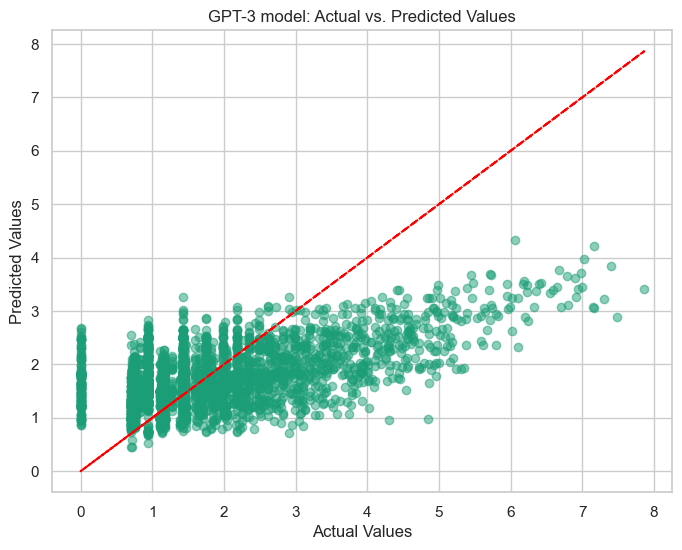

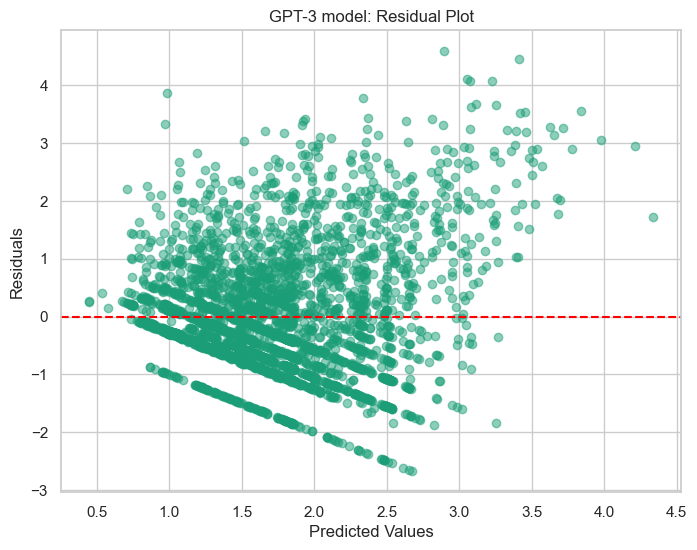

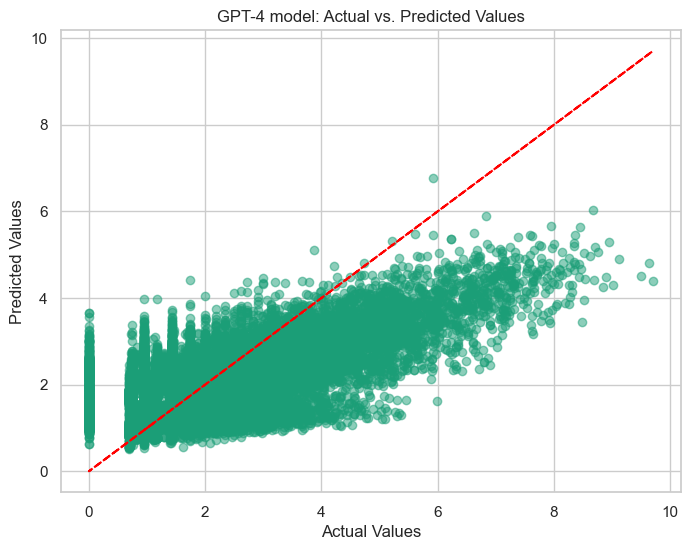

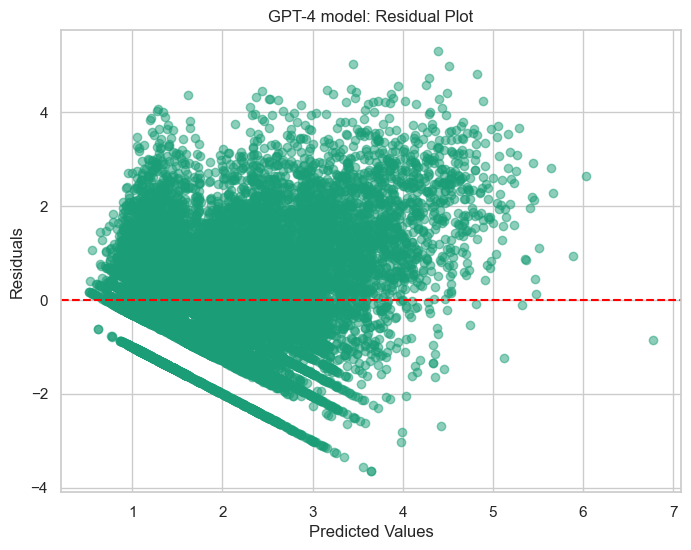

In [75]:
# Plot accuracy of the models
def plot_accuracy(model, name):
    actual_values = model['y_actual']
    predicted_values = model['y_pred']

    # Scatter plot of actual versus predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(actual_values, predicted_values, alpha=0.5)
    plt.plot(actual_values, actual_values, color='red', linestyle='--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(name + ": Actual vs. Predicted Values")
    plt.grid(True)
    plt.show()

    # Residual plot
    residuals = actual_values - predicted_values
    plt.figure(figsize=(8, 6))
    plt.scatter(predicted_values, residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(name + ": Residual Plot")
    plt.grid(True)
    plt.show()

    # Coefficient plot (if coefficients are available in the MLflow run)
    if "coefficients" in model:
        coefficients = model["coef"]
        plt.figure(figsize=(8, 6))
        sns.barplot(x=coefficients.index, y=coefficients.values)
        plt.xlabel("Independent Variables")
        plt.ylabel("Coefficients")
        plt.title("Coefficient Plot")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()
plot_accuracy(model=gpt3_model, name='GPT-3 model')
plot_accuracy(model=gpt4_model, name='GPT-4 model')

# Feature Plots

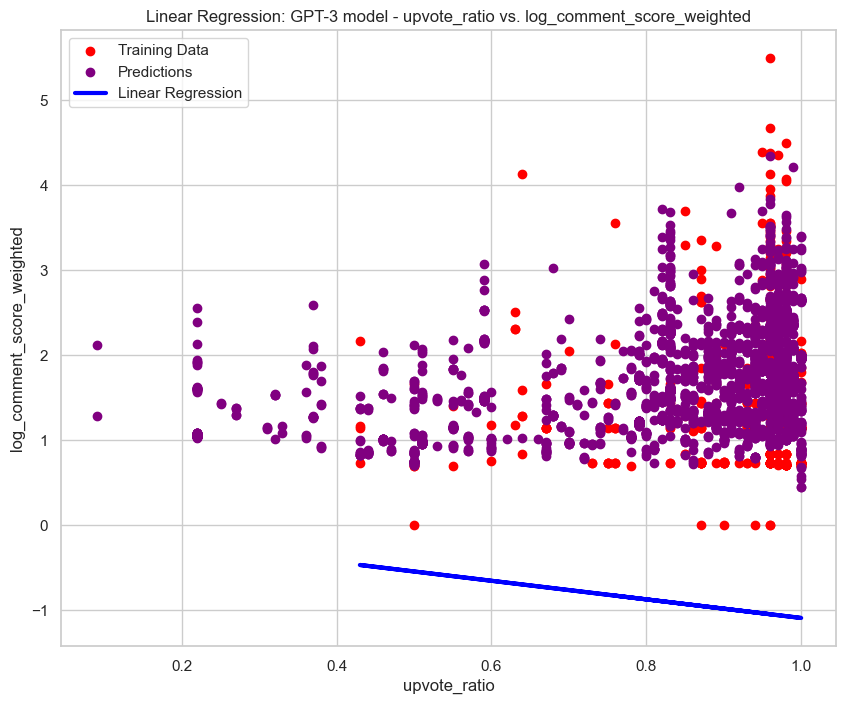

upvote_ratio=-1.0939423186545596


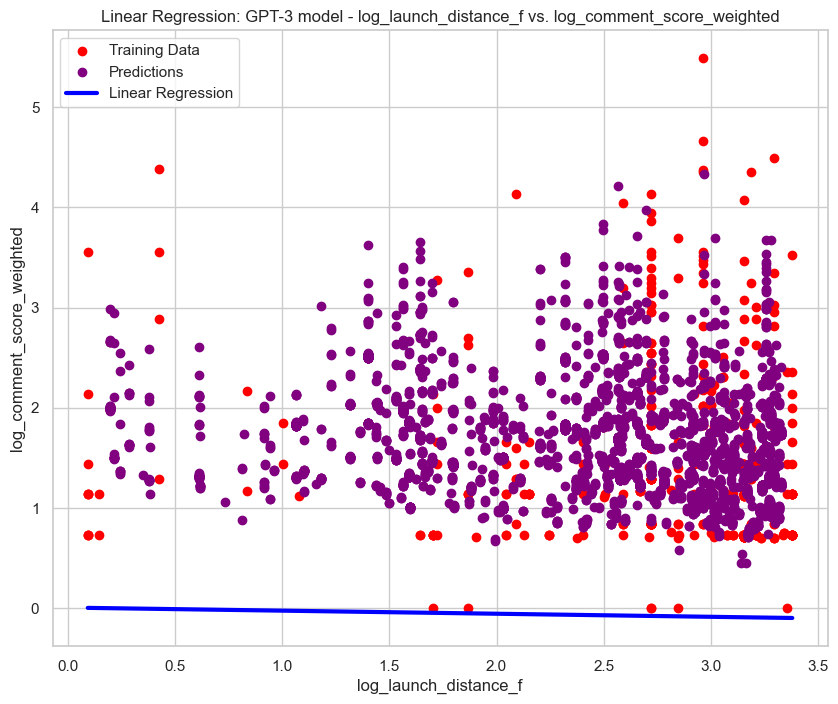

log_launch_distance_f=-0.030685776663097963


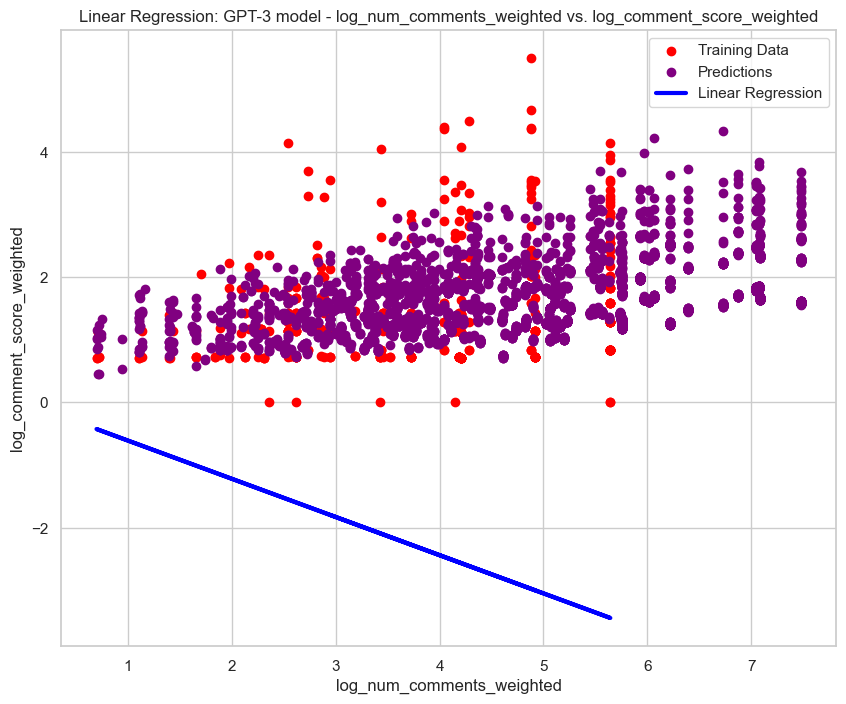

log_num_comments_weighted=-0.6097195943529656


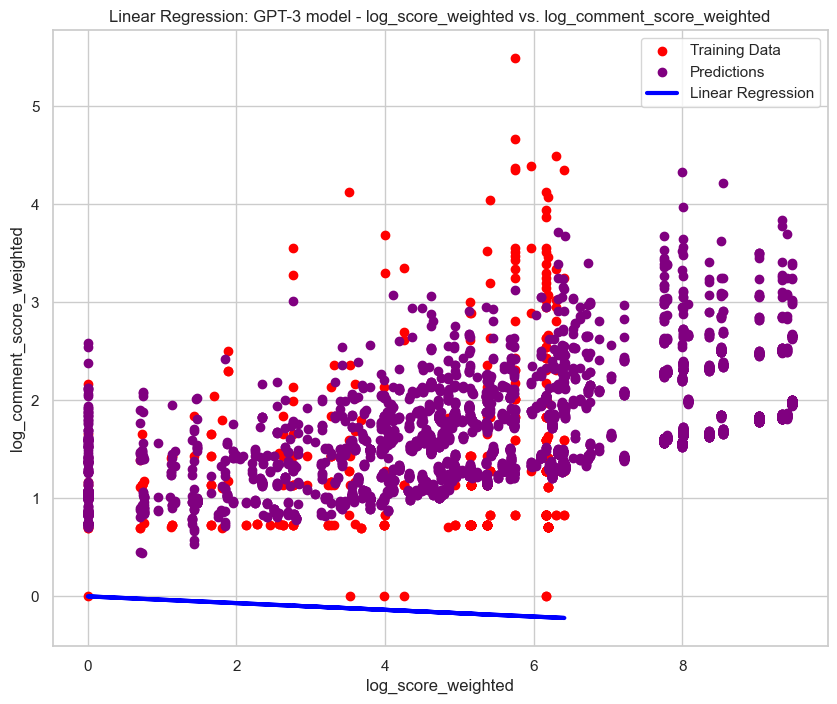

log_score_weighted=-0.03436805689159379


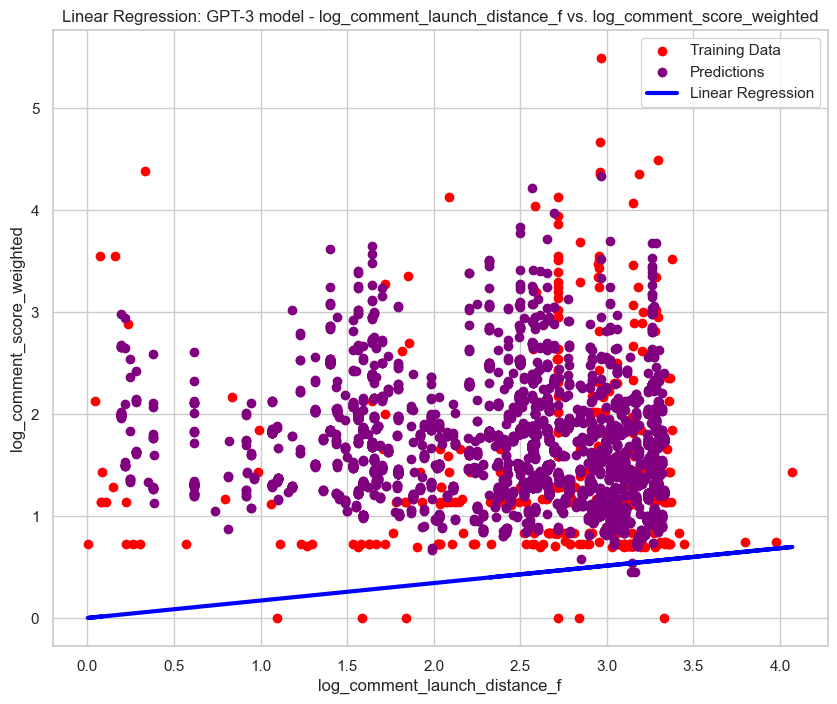

log_comment_launch_distance_f=0.17116448973977888


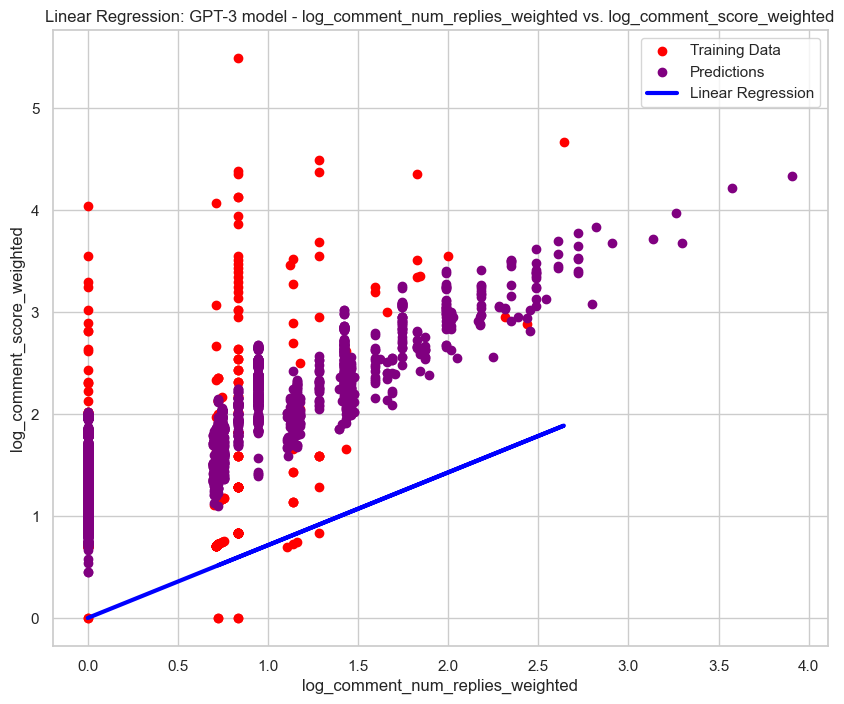

log_comment_num_replies_weighted=0.7144009674112437


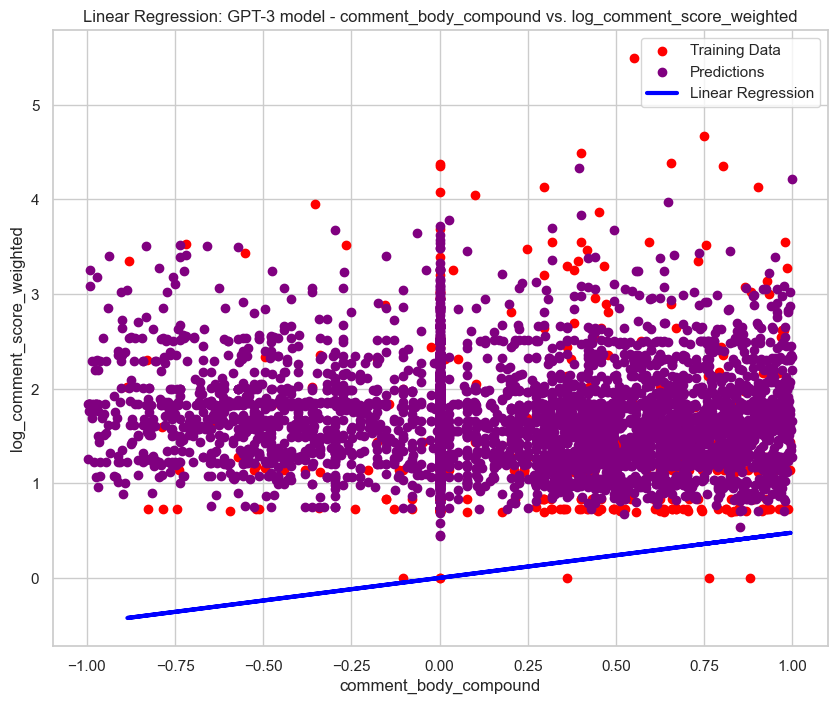

comment_body_compound=0.4786384491436137


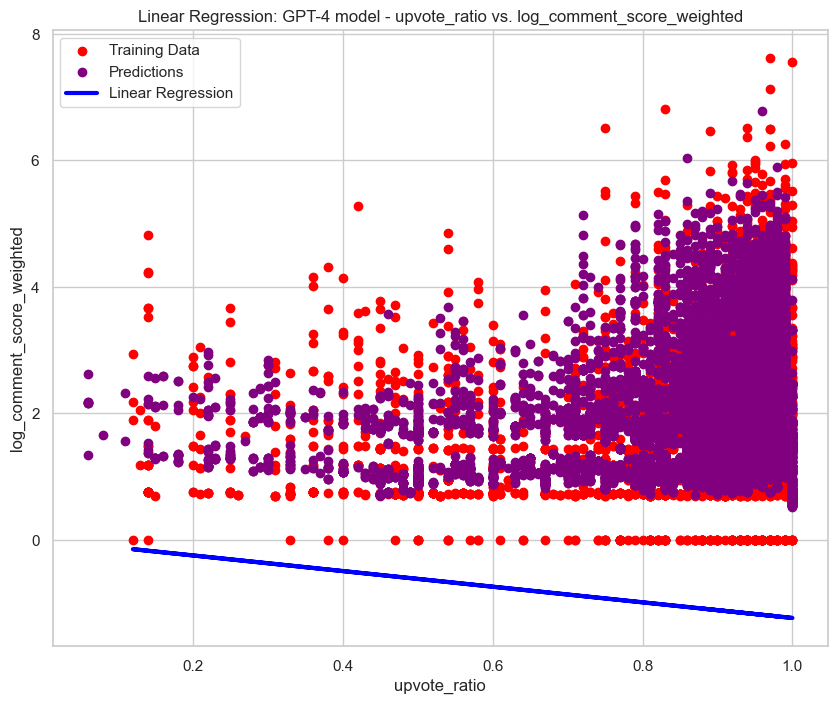

upvote_ratio=-1.235626160748309


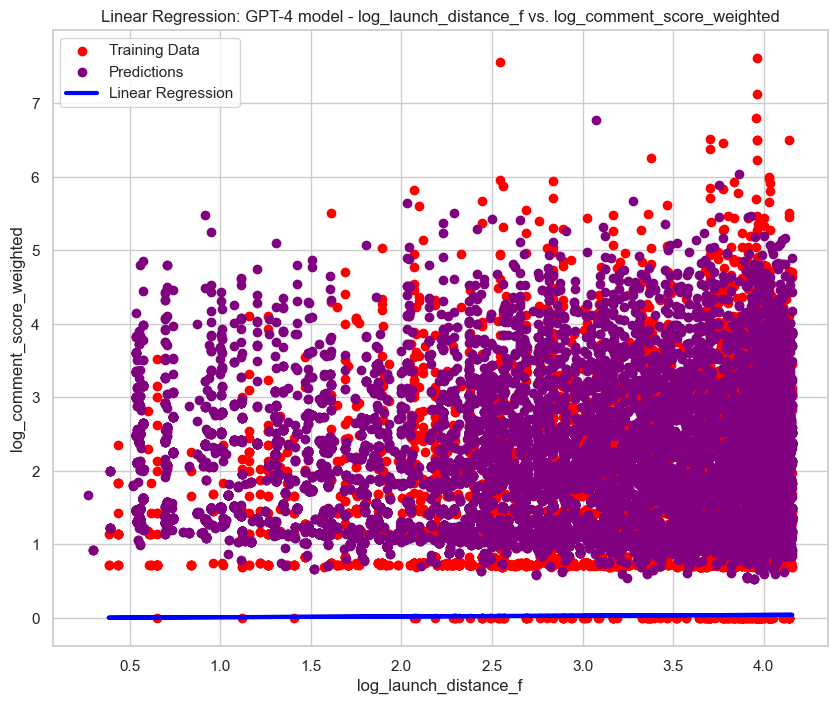

log_launch_distance_f=0.0104326638589613


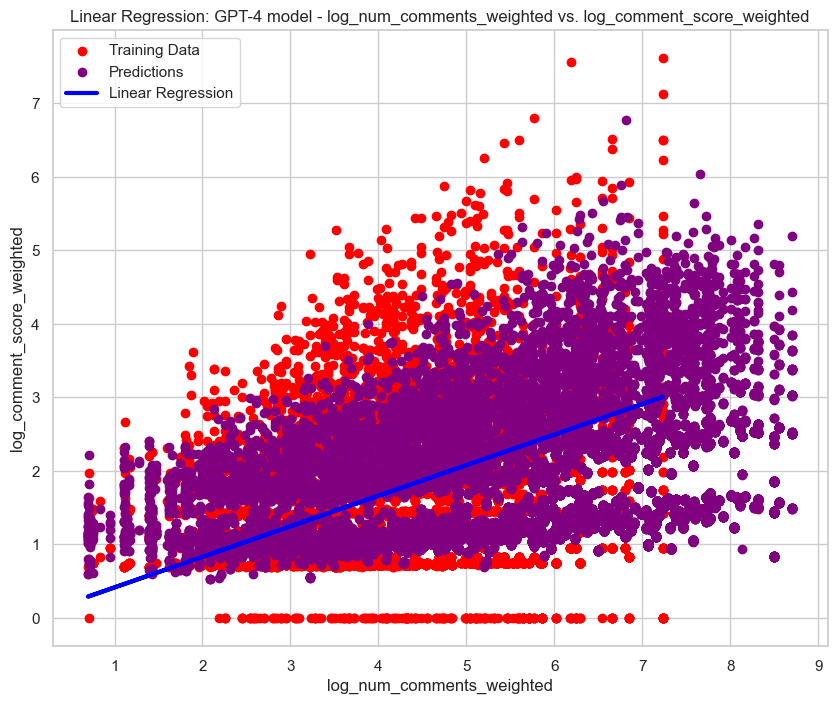

log_num_comments_weighted=0.4157140139207113


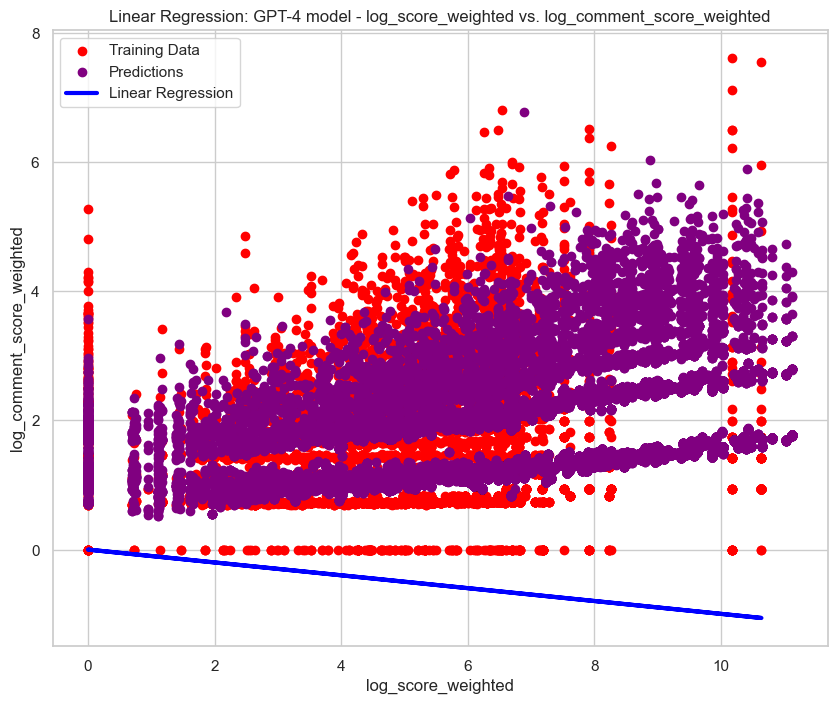

log_score_weighted=-0.09958539218793043


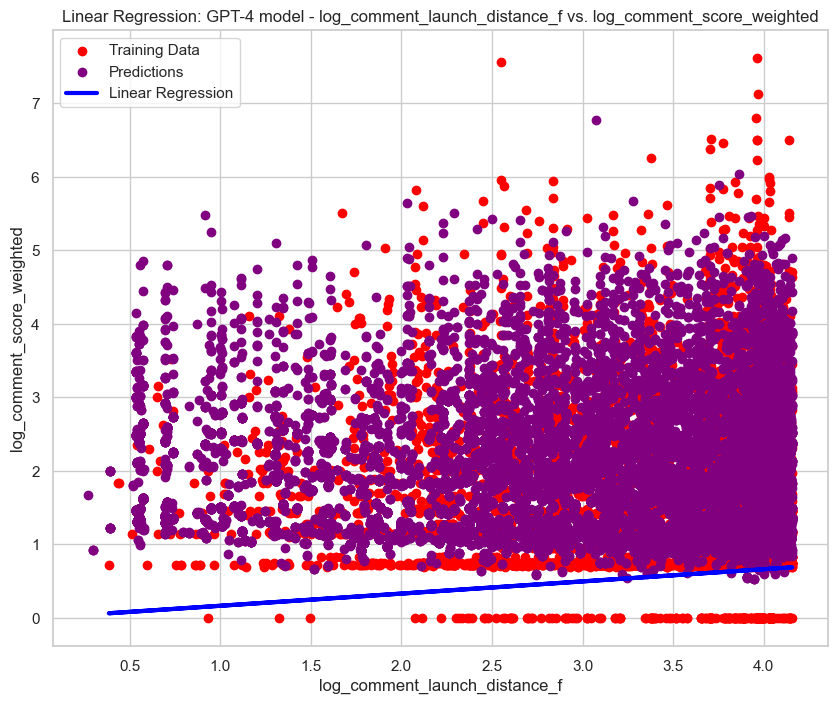

log_comment_launch_distance_f=0.1657570703079574


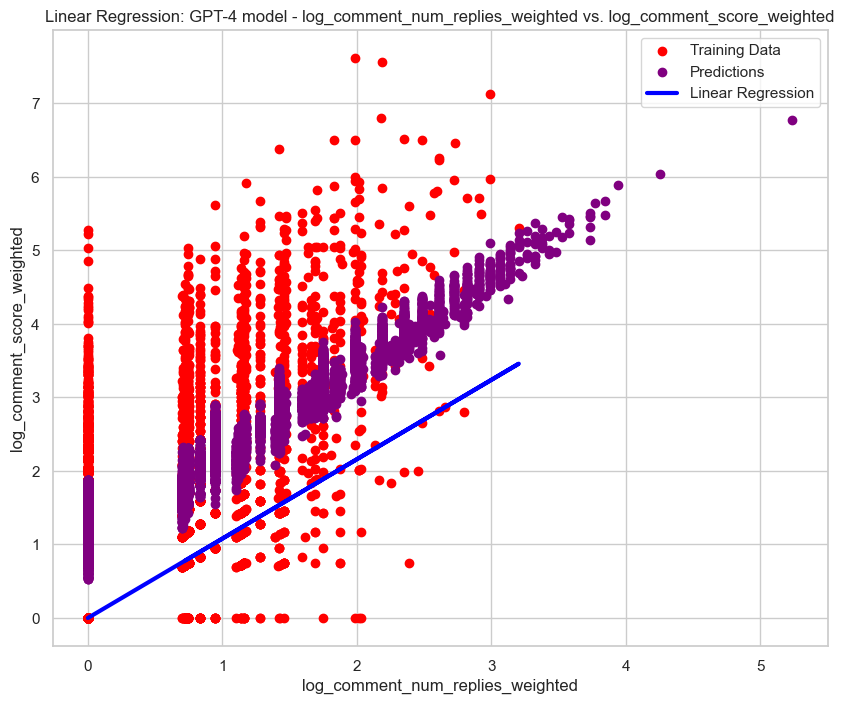

log_comment_num_replies_weighted=1.0792140199907891


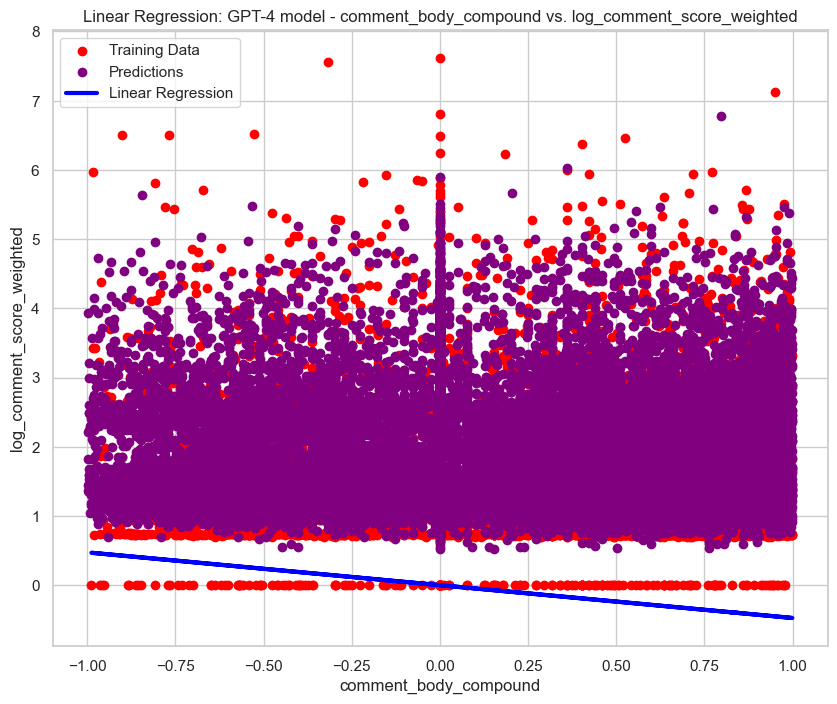

comment_body_compound=-0.47396120380057755


In [76]:
def plot_features(model, name):
    for coef in feature_names:
        feature = coef
        plt.scatter(model['X'][feature], model['y'], color='red', label='Training Data')
        plt.scatter(model['X_test'][feature], model['y_pred'], color='purple', label='Predictions')
        y_fit = model['X'][feature] * model['coef'][0][feature_names.index(feature)]
        plt.plot(model['X'][feature], y_fit, color='blue', linewidth=3, label='Linear Regression')
        plt.xlabel(f"{feature}")
        plt.ylabel(f"{target_name}")
        plt.title(f"Linear Regression: {name} - {feature} vs. {target_name}")
        plt.legend()
        plt.show()
        print(f"{coef}={model['coef'][0][feature_names.index(coef)]}")
plot_features(model=gpt3_model, name='GPT-3 model')
plot_features(model=gpt4_model, name='GPT-4 model')

# Categorical Distributions

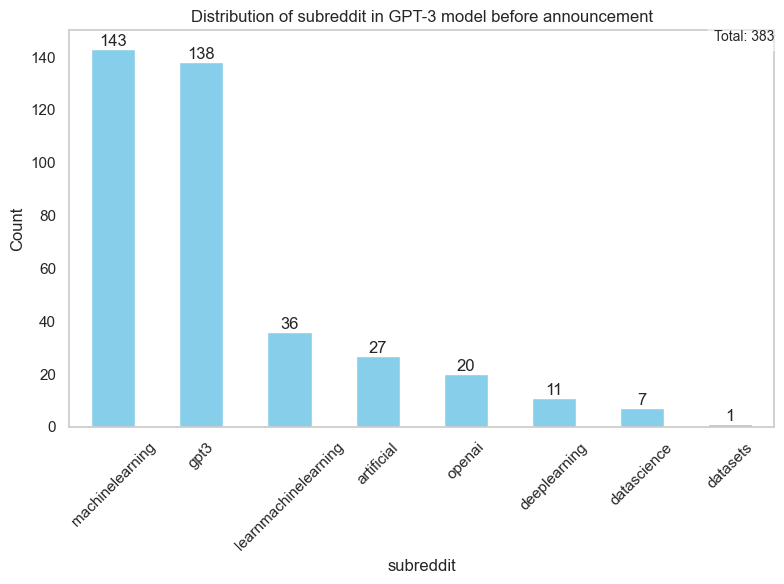

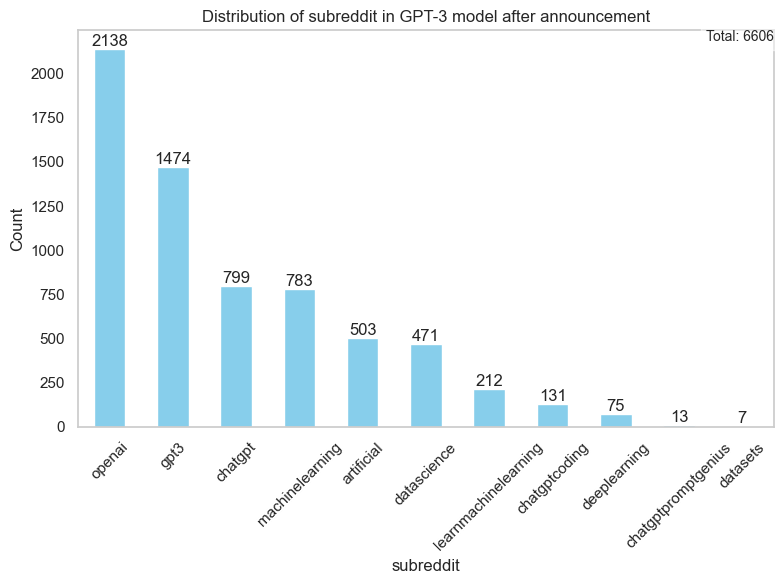

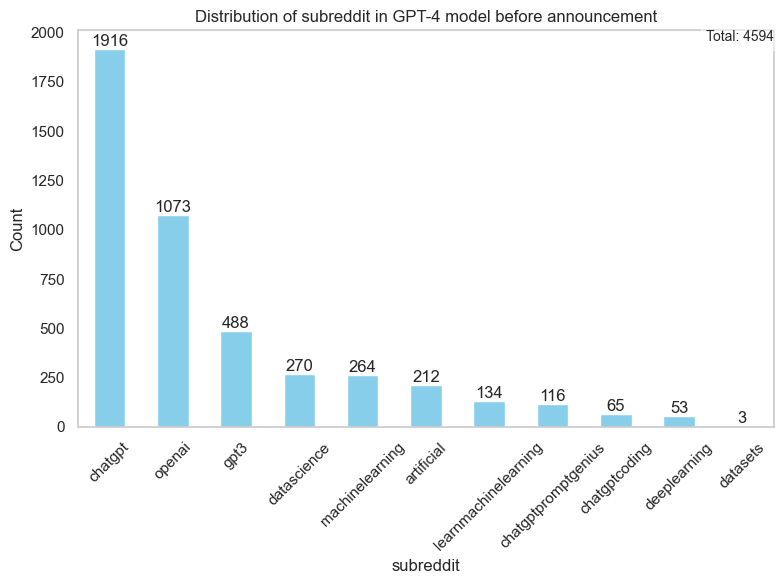

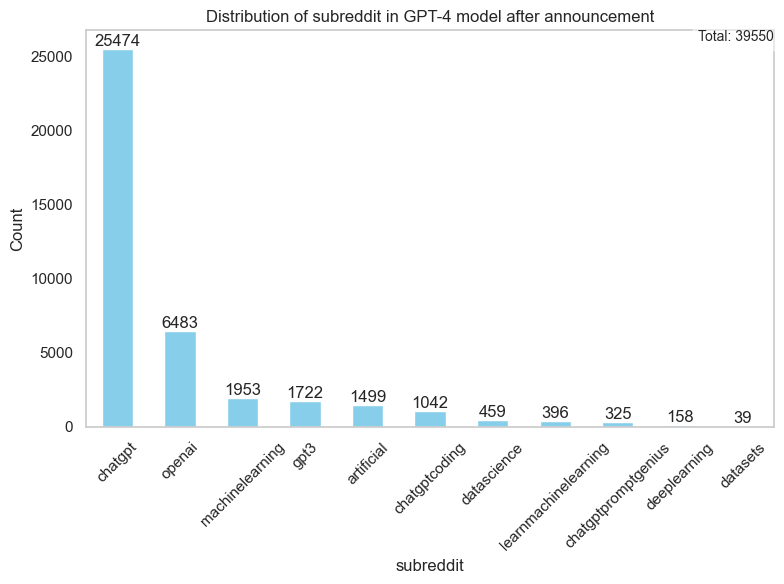

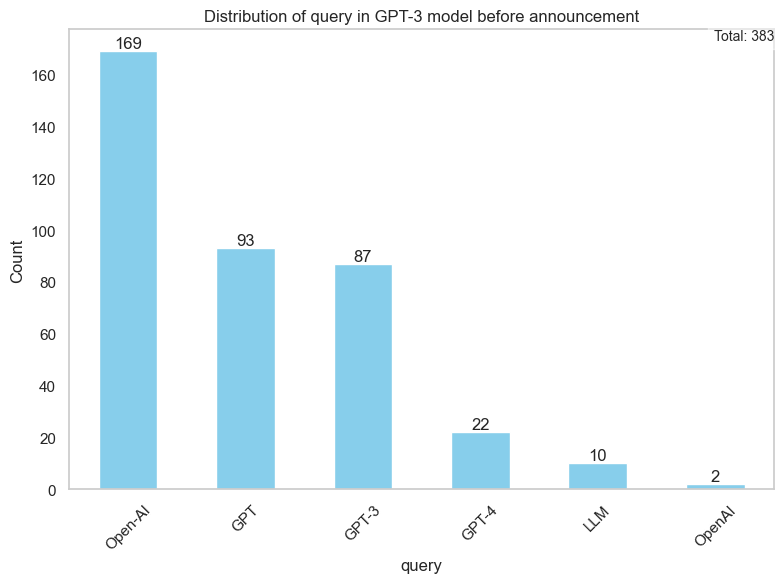

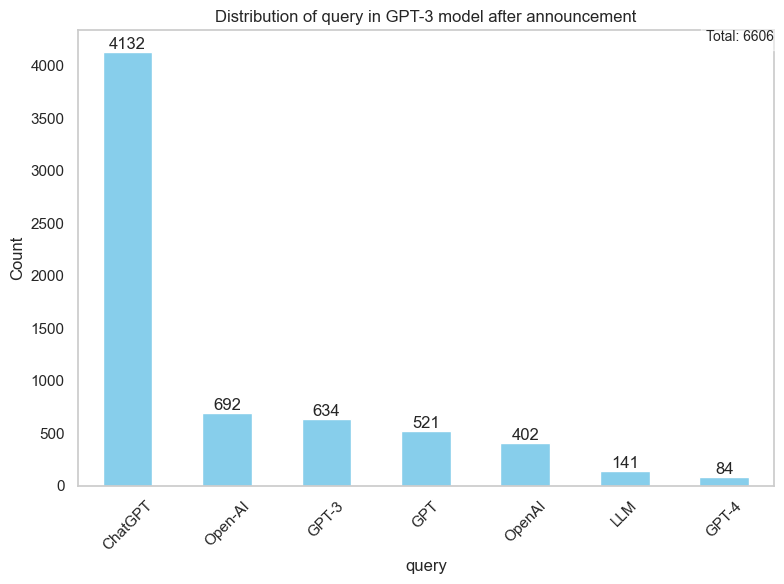

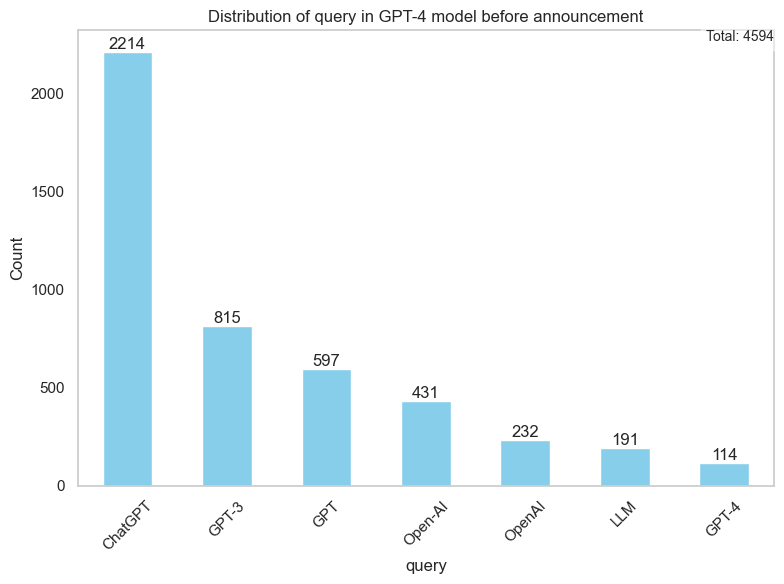

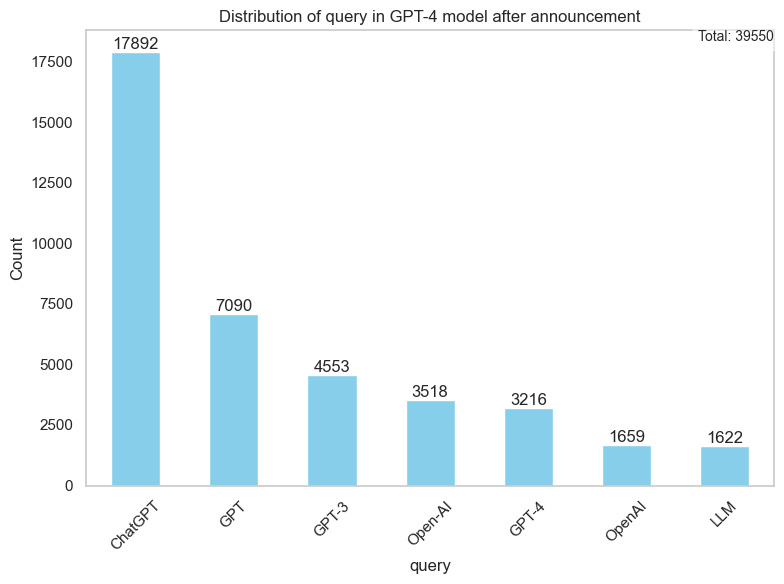

In [77]:
def plot_distributions(dataset, name, category):
    # Count the occurrences of each category value
    category_counts = dataset[category].value_counts()

    # Plot the distribution as a bar chart
    plt.figure(figsize=(8, 6))
    ax = category_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Distribution of {category} in {name}')
    plt.xlabel(category)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    ax.grid(False)  # Remove gridlines


    # Annotate each bar with its count
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom')
        
    # Add total count outside the plot
    total_count = dataset[category].count()
    plt.text(1, 1, f'Total: {total_count}', ha='right', va='top', transform=ax.transAxes, fontsize=10,
             bbox=dict(facecolor='white', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
for category in ['subreddit', 'query']:
    plot_distributions(dataset=df_gpt3_before, name='GPT-3 model before announcement', category=category)
    plot_distributions(dataset=df_gpt3_after, name='GPT-3 model after announcement', category=category)
    plot_distributions(dataset=df_gpt4_before, name='GPT-4 model before announcement', category=category)
    plot_distributions(dataset=df_gpt4_after, name='GPT-4 model after announcement', category=category)

# Heatmap of MLflow runs

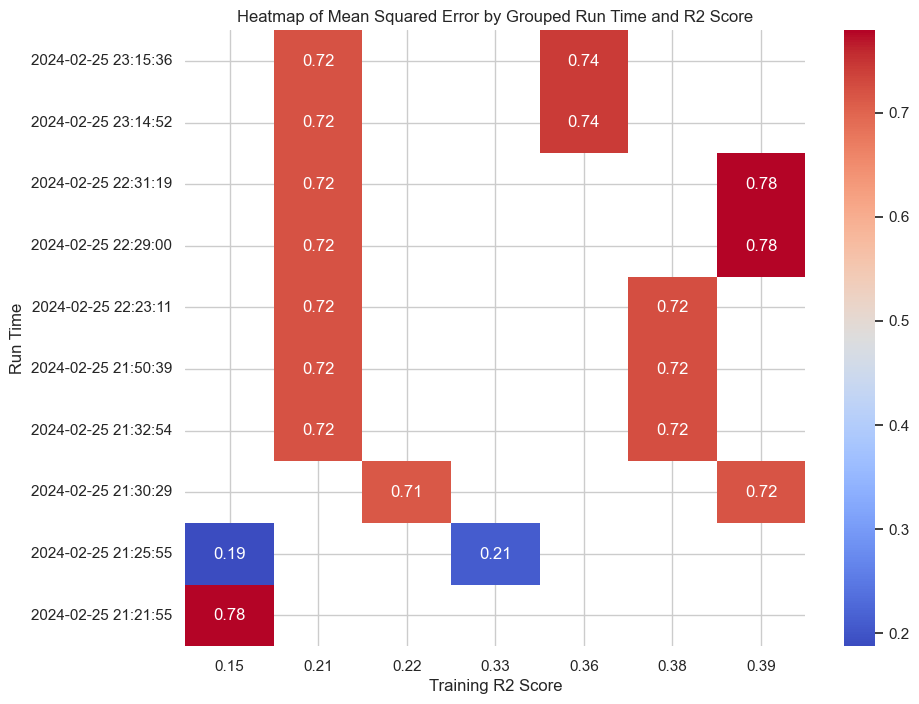

In [78]:
# Fetch the data from MLflow
experiments = mlflow.search_runs()

# Convert 'start_time' column to datetime
experiments['start_time'] = pd.to_datetime(experiments['start_time'])
# Format 'start_time' to include date, hour, minute, and second
experiments['start_time'] = experiments['start_time'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Trim the values in 'metrics.training_r2_score' to two decimal places
experiments['metrics.training_r2_score'] = experiments['metrics.training_r2_score'].apply(lambda x: round(x, 2))

# Sort by 'start_time' column in descending order
experiments_sorted = experiments.sort_values(by='start_time', ascending=False)

# Take every 4 experiments and collate them
experiments_sorted['start_time_grouped'] = experiments_sorted.groupby(experiments_sorted.index // 2)['start_time'].transform(lambda x: x.iloc[0])

# Take the most recent 5 experiments
num_experiments = 10
recent_experiments = experiments_sorted.head(num_experiments*2)

# Organize the data into a DataFrame
heatmap_data = recent_experiments.pivot_table(index='start_time_grouped', columns='metrics.training_r2_score', values='metrics.training_mean_squared_error')

# Sort the index in descending order
heatmap_data = heatmap_data.sort_index(ascending=False)

# Create the heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Heatmap of Mean Squared Error by Grouped Run Time and R2 Score')
plt.xlabel('Training R2 Score')
plt.ylabel('Run Time')
plt.show()